In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.animation as animation
from loguru import logger
from tqdm import tqdm

# Milestone 3 (Shear Wave Decay)

In [27]:
class Simulation:
    '''
    Simulation class for Lattice Boltzmann solver
    '''
    
    def __init__(self, nx=101, ny=101, scenario='explosion', epsilon=0.5, omega=0.05, T=500):
        '''
        Takes in simulation parameters and assigns to class attributes
        '''

        # 9x2 grid of velocity channels
        self.c_92 = np.array([
            [0,  0], 
            [0,  1], 
            [1,  0], 
            [0, -1], 
            [-1, 0],
            [1,  1], 
            [-1, -1],
            [1,  -1], 
            [-1, 1]]
        )
        
        # 1x9 grid of velocity channel weights
        self.w_9 = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
        
        self.nx, self.ny = nx, ny # grid dimensions
        self.scenario = scenario # scenario keyword (explosion, shear_wave_density, ...)
        self.omega = omega # collision factor
        self.epsilon = epsilon # perturbation factor
        self.T = T # time steps
    
    def initial_conditions(self):
        '''
        Returns the initial conditions on velocity and density for a simulation scenario
        '''
        
        if self.scenario == 'explosion':
            # uniform density
            rho_xy = np.ones((self.nx, self.ny), dtype=float) / (self.nx * self.ny)
            
            # zero velocity
            u_2xy = np.zeros((2, self.nx, self.ny), dtype=float)
            
            # add small amount of density to center of grid
            rho_xy[self.nx//2, self.ny//2] *= 1 + self.epsilon

        if self.scenario == 'shear_wave_density':
            # uniform density
            rho_xy = np.ones((self.nx, self.ny), dtype=float) / (self.nx * self.ny)
            
            # zero velocity
            u_2xy = np.zeros((2, self.nx, self.ny), dtype=float)
            
            # create meshgrid
            x, y = np.arange(self.nx), np.arange(self.ny)
            X, Y = np.meshgrid(x, y)
            
            # add sinusoidal density in x-direction
            rho_xy += self.epsilon * np.sin(2*np.pi/self.nx*X)

        if self.scenario == 'shear_wave_velocity':
            # uniform density
            rho_xy = np.ones((self.nx, self.ny), dtype=float) / (self.nx * self.ny)
            
            # zero velocity
            u_2xy = np.zeros((2, self.nx, self.ny), dtype=float)
            
            # create meshgrid
            x, y = np.arange(self.nx), np.arange(self.ny)
            X, Y = np.meshgrid(x, y)
            
            # add sinusoidal velocity in x direction
            u_2xy[0] += self.epsilon * np.sin(2*np.pi/self.ny*Y)
            
        return u_2xy, rho_xy
    
    ################ Simulation Code ################        
    
    def stream_inplace(self, f_9xy):
        '''
        Stream the probability density function inplace
        '''
        
        # iterate over channels
        for i in range(0, 9):
            
            # roll probability density function in direction of ith channel
            f_9xy[i] = np.roll(f_9xy[i], shift=self.c_92[i], axis=(0, 1))


    def density(self, f_9xy) -> np.array:
        '''
        Returns the overall density over all velocity channels
        '''
        
        # sums probability density function over channels
        # return np.einsum('ijk->jk', f_9xy)
        return np.sum(f_9xy, axis=0)


    def velocity(self, f_9xy) -> np.array:
        '''
        Returns average velocity over all velocity channels
        '''
        
        # sums probability density function over channels and weighs by discretized velocity
        u_2xy = np.einsum('ia,ijk->ajk', self.c_92, f_9xy)
        
        # u_2xy = np.zeros((2, self.nx, self.ny))
        # for i in range(0, 9):
        #     u_2xy[0] += self.c_92[i][0] * f_9xy[i]
        #     u_2xy[1] += self.c_92[i][1] * f_9xy[i]
            
        rho_xy = self.density(f_9xy) # gets density 

        return u_2xy / rho_xy


    def equilibrium_function(self, u_2xy, rho_xy) -> np.array:
        '''
        Returns the equilibrium function
        '''
        
        # sums average velocities over x and y directions
        squ_xy = np.einsum('ajk,ajk->jk', u_2xy, u_2xy)
        # squ_xy = (u_2xy[0] + u_2xy[1]) ** 2
        
        # initializes equilibrium probability density function
        f_eq_9xy = np.zeros((9, self.nx, self.ny))
        
        # iterate over channels
        for i in range(0, 9):
            
            # sums average velocities over x and y directions and weighs by ith velocity channel
            cu_xy = np.einsum('a,ajk->jk', self.c_92[i], u_2xy)
            # cu_xy = self.c_92[i][0] * u_2xy[0] + self.c_92[i][1] * u_2xy[1]
            
            # equation X
            f_eq_9xy[i] = self.w_9[i] * rho_xy * (1.0 + 3.0 * cu_xy + 4.5 * cu_xy**2 - 1.5 * squ_xy)

        return f_eq_9xy


    def collision(self, f_9xy):
        '''
        Collision part of the Boltzmann Transport Equation (BTE)
        '''
        
        # gets average velocities and overall density
        u_2xy, rho_xy = self.velocity(f_9xy), self.density(f_9xy)        
        
        # gets equilibrium probability density function
        f_eq_9xy = self.equilibrium_function(u_2xy, rho_xy)
        
        # equation X
        f_col_9xy = self.omega * (f_eq_9xy - f_9xy)

        return f_col_9xy


    def run_simulation(self):
        '''
        Main loop for Lattice Boltzmann solver
        '''
        
        # gets initial conditions on average velocity and overall density
        u_2xy, rho_xy = self.initial_conditions()
        self.init_u, self.init_rho = u_2xy, rho_xy # records for plotting
    
        # gets equilbrium probability density function
        f_9xy = self.equilibrium_function(u_2xy, rho_xy)

        self.fs = [f_9xy] # records for plotting
        
        # iterate over time steps
        for t in tqdm(range(self.T), desc='t='):
            
            # streams probability density function
            self.stream_inplace(f_9xy)
            
            # equation X
            f_9xy = f_9xy + self.collision(f_9xy)

            self.fs.append(f_9xy) # records for plotting
        
    ################ Helper Functions ################
            
    def check_mass_conservation(self):

        rhos = np.array([self.density(f) for f in self.fs])
        masses = [np.sum(rho) for rho in rhos]

        try:
            assert np.allclose(masses, masses[0])
            logger.info('mass conserved')
        except AssertionError:
            logger.warning('mass not conserved')
            
            
    def plot_velocity_over_x(self):
        fig, ax = plt.subplots(figsize=(6, 4))
        
        cmap = mpl.cm.viridis_r
        norm = mpl.colors.BoundaryNorm(np.arange(self.T / 10), cmap.N, extend='both')
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

        for i, f in enumerate(self.fs):
            if i % 10 == 0:
                im = ax.plot(np.arange(self.nx), self.velocity(f)[0][:,0], color=sm.to_rgba(i/10))

        ax.plot(np.arange(self.nx), self.init_u[0][:,0], color='black', linestyle='dashed', label='initial')
                
        ax.set_xlabel('x-axis (nx)')
        ax.set_ylabel('velocity (u)')

        cbar = fig.colorbar(sm, ax=ax)
        cbar.ax.set_title('time (t x 10)')
        ax.legend()

        fig.tight_layout()
        
        fig.savefig(f'velocity_over_x_{self.scenario}_{self.omega}_{self.epsilon}.pdf', dpi=600)
        
        plt.show()
        

    def plot_density_over_x(self):
        fig, ax = plt.subplots(figsize=(6, 4))
        
        cmap = mpl.cm.viridis_r
        norm = mpl.colors.BoundaryNorm(np.arange(self.T / 10), cmap.N, extend='both')
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

        for i, f in enumerate(self.fs):
            im = ax.plot(np.arange(self.nx), self.density(f)[0,:])

        # ax.plot(np.arange(self.nx), self.init_u[0][:,0], color='black', linestyle='dashed', label='initial')
                
        ax.set_xlabel('x-axis (nx)')
        ax.set_ylabel('density (rho)')

        cbar = fig.colorbar(sm, ax=ax)
        cbar.ax.set_title('time (t x 10)')
        ax.legend()

        fig.tight_layout()
        plt.show()
        

    def plot_density_over_time(self):
        fig, axes = plt.subplots(ncols=int(self.T/10), figsize=(int(self.T/10)*5, 4))
        
        for i, f in enumerate(self.fs):
            if i % 10 == 0:
                axes[i//10-1].imshow(self.density(f), vmin=np.min(self.density(self.fs[0])), vmax=np.max(self.density(self.fs[0])))
                axes[i//10-1].set_xticks([])
                axes[i//10-1].set_yticks([])
                axes[i//10-1].set_title(f't = {i}')
        
        fig.tight_layout()
        
        fig.savefig(f'density_over_time_{self.scenario}_{self.omega}_{self.epsilon}.pdf', dpi=600)
        plt.show()
        
    
    def plot_amplitude_over_time(self):
        fig, ax = plt.subplots(figsize=(5, 4))
        
        time = np.arange(self.T+1)
        nu = (1/3)*((1/self.omega)-(1/2))
        decay_true = self.epsilon * np.exp(-nu*(2*np.pi/self.nx)**2*time)
        
        ax.plot(time, decay_true, label='true')
        
        decay_est = np.zeros(self.T+1)
        for i, f in enumerate(self.fs):
            decay_est[i] = np.max(self.velocity(f)[0][:,0])
            
        ax.plot(time, decay_est, label='est.')
        
        ax.set_xlabel('time (t)')
        ax.set_ylabel('amplitude')
        ax.legend()
        
        fig.tight_layout()
        
        fig.savefig(f'amplitude_over_time_{self.scenario}_{self.omega}_{self.epsilon}.pdf', dpi=600)
        
        plt.show()

t=: 100%|██████████| 1000/1000 [00:01<00:00, 701.36it/s]


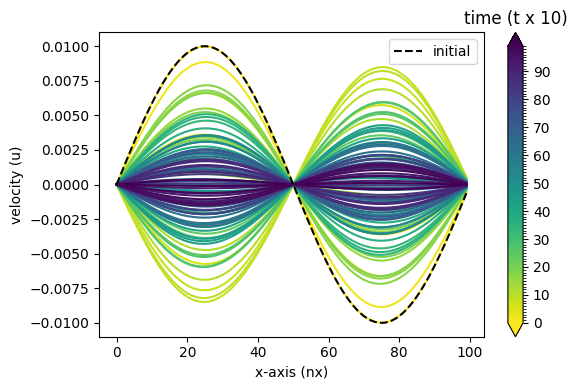

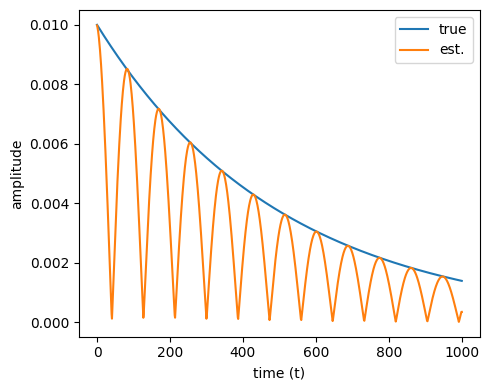

In [28]:
sim = Simulation(
    nx=100,
    ny=100,
    scenario='shear_wave_velocity',
    epsilon=0.01,
    omega=0.5,
    T=1000,
)

sim.run_simulation()
# sim.plot_density_over_time()

# sim.check_mass_conservation()
sim.plot_velocity_over_x()
# sim.plot_density_over_x()
sim.plot_amplitude_over_time()